In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

Pour être sûr d'utiliser Tensorflow 2.0 :

In [19]:
assert hasattr(tf, "function")

Cette fonction ouvre un fichier C_maps.txt en lecture et récupère les 22 coefficients et les retourne sous forme d'une matrice

In [20]:
def get_data(file_path):
    
    file = open(file_path, "r")

    allText = file.read()

    words = list(map(str, allText.split()))

    matrice_height = int(len(words) / 30)
    matrice = np.ones((matrice_height, 24))

    emplacement = 20
    iter1 = 0
    for i in range(emplacement, int(len(words) / 30) + emplacement):
        iter2 = 0
        for j in range(emplacement + 6, emplacement + 30):
            matrice[(iter1, iter2)] = words[j]
            iter2 += 1
        iter1 += 1
        emplacement += 30
    X_2 = np.delete(matrice, 1, 1)
    X_final = np.delete(X_2, 10, 1)
    
    file.close()
    
    return X_final

Cette fonction ouvre un fichier ctf en lecture et récupère les 3 coefficients d'Euler pour les retourner sous forme de matrice (x, 3)

In [21]:
def read_ctf(file_path):
    
    file2 = open(file_path, "r")
    
    allText2 = file2.read()
    words2 = list(map(str, allText2.split()))
    
    nb_debut_donnees = 88
    nb_mots = len(words2) - nb_debut_donnees
    nb_mots_par_ligne = 11
    
    nb_ligne_matrice = int(nb_mots / nb_mots_par_ligne)
    print("nb_ligne_matrice = " + str(nb_ligne_matrice))
    nb_colonne_matrice = 3
    matrice = np.empty((nb_ligne_matrice, nb_colonne_matrice))
    emplacement = 0
    
    print("Extraction des données à partir du fichier ....")
    for i in range(nb_debut_donnees, nb_mots + nb_debut_donnees, nb_mots_par_ligne):
        matrice[(emplacement, 0)] = words2[i + 5]
        matrice[(emplacement, 1)] = words2[i + 6]
        matrice[(emplacement, 2)] = words2[i + 7]
        emplacement += 1
    print("ok !")    
    file2.close()
    
    return matrice

Cette fonction fait faire des prédiction au modèle et renvoie le score, mae, rmse, r2

In [22]:
def run_experiment(model):
    y_pred = model.predict(X_test)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

cette fonction renvoie le nombre d'erreur de 1 degré ou plus de la prédiction par rapport aux valeurs réelles
et renvoie les valeurs X d'entrée et y de sortie pour lesquels le modèle prédit mal, sous forme de matrices erreur_x, erreur_y

In [23]:
def pourcentage_erreur(y_pred, y_test, x_test):
   
    err = 0
    marge_derreur = 1 # 1 degre
    erreur_y = np.empty((1, 3), dtype=float)
    erreur_x = np.empty((1, 22), dtype=float)
   
    for i in range(y_pred.shape[0]):
       
        for j in range(y_pred.shape[1]):
           
            error = abs(y_pred[i][j] - y_test[i][j])
            if error >= marge_derreur:
               
                # print(error)
                err += 1
               
                erreur_y = np.append(erreur_y, [y_test[i]], axis=0)
                erreur_x = np.append(erreur_x, [x_test[i]], axis=0)
               
                break
               
    erreur_y = np.delete(erreur_y, 0, axis=0)
    erreur_x = np.delete(erreur_x, 0, axis=0)
    
    for y in erreur_y:
        for i in range(len(y)):
            y[i] = round(y[i], 3)
    for x in erreur_x:
        for j in range(len(x)):
            x[j] = round(x[j], 3)
    
    message = "le pourcentage d'erreur est de "+str((err / y_pred.shape[0]) * 100)+", "+str(err)+" / "+str(y_pred.shape[0])
    return message, erreur_y, erreur_x, err

In [24]:
def calculate_error(y_pred, y_test, x_test):
   
    err = 0
    marge_derreur = 1 # 1 degre
   
    for i in range(y_pred.shape[0]):
       
        for j in range(y_pred.shape[1]):
           
            error = abs(y_pred[i][j] - y_test[i][j])
            
            if error >= marge_derreur:
                
                err += 1
                break
    
    message = "le pourcentage d'erreur est de "+str((err / y_pred.shape[0]) * 100)+", "+str(err)+" / "+str(y_pred.shape[0])
    return message

X matrice d'entrée de dimension (250000, 22)

In [50]:
file_in_path = "datas/C_maps_2.txt"
X = get_data(file_in_path)

In [26]:
X[0]

array([-4.53668256,  0.35552737,  0.23715782, -0.22702117,  0.33998304,
       -4.85874244,  2.45536086,  0.31531157,  0.02660497, -8.00376109,
        0.91285978,  0.52324844,  0.28278966, -0.57352367,  4.32920903,
       -2.18401481, -0.53856772, -0.03053514, -0.00904849,  0.37964889,
       -3.052588  ,  4.1412104 ])

Y matrice de dimension (250000, 3) correspondant aux valeurs de sortie q'on attend

In [51]:
file_out_path = "datas/exercise2.ctf"
y = read_ctf(file_out_path)

nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !


In [28]:
y[:10]

array([[262.098,  56.533,  43.17 ],
       [155.52 ,  57.101,  40.909],
       [333.114,  57.013,  41.125],
       [ 89.675,  56.815,  48.542],
       [ 16.423,  56.866,  41.327],
       [279.446,  56.744,  45.53 ],
       [235.51 ,  57.147,  44.19 ],
       [174.968,  56.346,  48.163],
       [ 90.722,  57.042,  46.127],
       [255.169,  55.341,  44.539]])

In [29]:
X

array([[-4.53668256,  0.35552737,  0.23715782, ...,  0.37964889,
        -3.052588  ,  4.1412104 ],
       [-4.45146434,  0.39495335, -0.67666611, ..., -0.7051953 ,
        -4.82521392, -1.69596936],
       [-4.46331098, -0.34394981,  0.65970949, ...,  0.62985437,
        -5.09400373, -0.50322898],
       ...,
       [-4.57298939,  0.10951005,  0.00527934, ..., -0.05835065,
         4.26223576, -2.90330867],
       [-4.48711632, -0.20266841, -0.62045815, ...,  0.54684302,
         3.99854768, -3.20965205],
       [-4.56768898,  0.18845715, -0.01307981, ..., -0.15755533,
         1.01992981, -5.05343945]])

Nous divisons notre jeu de données en jeu d'entraînement, X_train, y_train et en jeu de test, X_test, y_test
le pourcentage de données de test est précisé avec le paramètre test_size, ici de 20%. random_state permet d'avoir le même mélange de données pour pouvoir comparer des modèles entre eux

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [40]:
y_train

array([[255.345,  55.944,  46.056],
       [ 18.18 ,  55.417,  44.979],
       [113.271,  56.696,  48.033],
       ...,
       [201.353,  56.417,  44.685],
       [ 46.988,  57.272,  41.112],
       [155.91 ,  56.922,  46.054]])

Importer un modèle qu'on a sauvegardé auparavant dans un fichier h5

In [67]:
model = keras.models.load_model('h5/nouveau_hasan.h5')

Ou on définit notre modèle, entrée de de taille 22 avec quatres couches intermédiaire composés de 256, 128, 64 et 32 neurones avec fonction d'activation Relu et dernière couche, de sortie, de taille 3

In [41]:
model = keras.Sequential()

model.add(Input(shape=(22,)))

model.add(layers.Dense(256, activation="relu")),

model.add(layers.Dense(128, activation="relu")),

model.add(layers.Dense(64, activation="relu")),

model.add(layers.Dense(3))

On définit notre optimiseur et la vitesse d'apprentissage

on précise à notre modèle notre fonction de perte mae, mean absolute error, l'optimiseur et le métrique

In [42]:
model.compile(
    optimizer='adam',
    loss="mae",
    metrics=["accuracy"]
)

On entraîne le modèle en précisant nos données d'entraînement, X_train et y_train, le batch_size qui est le nombre de fois qu'on montre nos données au modèle avant qu'il ajuste ses paramètres, le nombre d'epochs qui est le nombre d'entraînement et nos données de valisation, X_test et y_test

In [43]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('model_dl.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [44]:
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/30
6214/6250 [============================>.] - ETA: 0s - loss: 10.0018 - accuracy: 0.9453
Epoch 00001: val_loss improved from inf to 4.50593, saving model to model_dl.h5
6250/6250 [==============================] - 4s 650us/step - loss: 9.9684 - accuracy: 0.9455 - val_loss: 4.5059 - val_accuracy: 0.9752
Epoch 2/30
6157/6250 [============================>.] - ETA: 0s - loss: 3.6006 - accuracy: 0.9843
Epoch 00002: val_loss improved from 4.50593 to 3.04872, saving model to model_dl.h5
6250/6250 [==============================] - 4s 628us/step - loss: 3.5947 - accuracy: 0.9843 - val_loss: 3.0487 - val_accuracy: 0.9797
Epoch 3/30
6243/6250 [============================>.] - ETA: 0s - loss: 2.8981 - accuracy: 0.9868
Epoch 00003: val_loss improved from 3.04872 to 2.68494, saving model to model_dl.h5
6250/6250 [==============================] - 4s 674us/step - loss: 2.8972 - accuracy: 0.9868 - val_loss: 2.6849 - val_accuracy: 0.9862
Epoch 4/30
6142/6250 [============================>.

Epoch 29/30
6214/6250 [============================>.] - ETA: 0s - loss: 1.2587 - accuracy: 0.9936
Epoch 00029: val_loss did not improve from 1.10856
6250/6250 [==============================] - 4s 718us/step - loss: 1.2582 - accuracy: 0.9936 - val_loss: 1.3227 - val_accuracy: 0.9921
Epoch 30/30
6248/6250 [============================>.] - ETA: 0s - loss: 1.2492 - accuracy: 0.9933
Epoch 00030: val_loss improved from 1.10856 to 0.86498, saving model to model_dl.h5
6250/6250 [==============================] - 4s 679us/step - loss: 1.2491 - accuracy: 0.9933 - val_loss: 0.8650 - val_accuracy: 0.9967


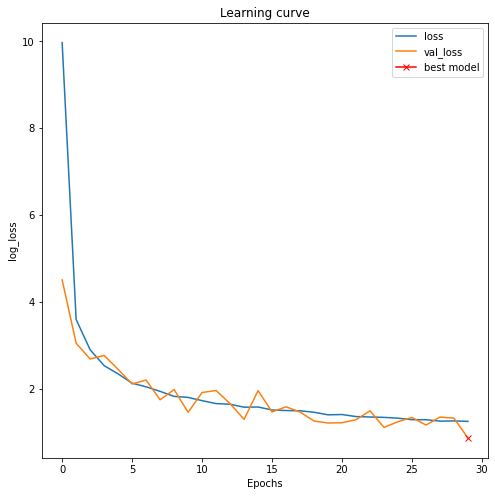

In [45]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

on demande au modèle de faire des prédictions pour les valeurs de X_test, de dimension (50000, 22).
val_predictions aura une dimension de (50000, 3)

In [52]:
val_predictions = model.predict(X_test)

On affiche les dix premières valeurs de prédictions (val_predictions) et les valeurs réelles attendues (y_test)

In [53]:
print("y_test : \n", y_test[:10])
print("=====================================")
print("y_pred : \n", val_predictions[:10])

y_test : 
 [[238.12   56.771  45.008]
 [312.516  56.229  43.907]
 [  4.188  56.151  45.955]
 [288.417  55.477  44.926]
 [222.128  55.859  43.357]
 [139.528  56.78   49.055]
 [347.173  55.879  43.91 ]
 [  1.74   56.774  48.945]
 [274.916  57.279  47.987]
 [298.611  56.402  43.524]]
y_pred : 
 [[238.0712     56.77033    45.03514  ]
 [312.4449     56.237186   43.866974 ]
 [  4.2220116  56.127884   45.90265  ]
 [288.3426     55.484077   44.886963 ]
 [222.0434     55.85043    43.38147  ]
 [139.34554    56.790813   49.05146  ]
 [347.05927    55.93183    43.85106  ]
 [  1.706047   56.7986     48.828247 ]
 [274.9542     57.221664   47.971306 ]
 [298.44095    56.385254   43.476334 ]]


On calcule l'erreur moyenne absolue en donnant à la fonction les valeurs prédites et réelles

In [78]:
val_mae = mean_absolute_error(val_predictions, y_test)
print("Validation MAE for Model: {}".format(val_mae))

Validation MAE for Model: 0.11446011799682604


In [79]:
val_mse = mean_squared_error(y_test, val_predictions)
print("Validation MSE for Model: {}".format(val_mse))

Validation MSE for Model: 7.866851689174126


In [56]:
y_test.shape

(50000, 3)

On affiche trois graphiques pour chaque valeur d'Euler, en x les valeurs réelles et en y les valeurs prédites

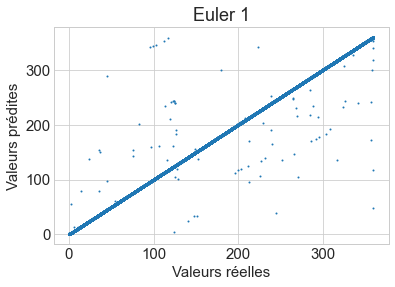

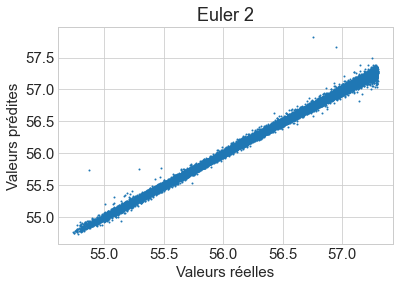

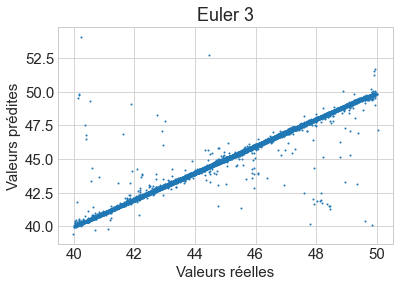

In [80]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_test[:, i], val_predictions[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="Valeurs réelles", ylabel="Valeurs prédites")
    plt.show()

On affiche le nombre d'erreurs de 1 degré ou plus de notre modèle

In [81]:
message = calculate_error(val_predictions, y_test, X_test)
print(message)

le pourcentage d'erreur est de 0.258, 129 / 50000


on mesure la qualité de prédiction de notre modèle avec l'écart quadratique moyen, mae et le coefficient de détermination

In [61]:
run_experiment(model)

R^2 :  0.995237175360241
MAE : 0.11446011799682604
RMSE: 2.804790845887466


On importe d'autres données que le modèle n'a jamais vu pour le tester

In [82]:
X_3 = get_data("datas/C_maps_3.txt")
y_3 = read_ctf("datas/exercise3.ctf")
X_4 = get_data("datas/C_maps_4.txt")
y_4 = read_ctf("datas/exercise4.ctf")
X_5 = get_data("datas/C_maps_5.txt")
y_5 = read_ctf("datas/exercise5.ctf")

nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !
nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !
nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !


on fait prédire nos nouvelles données et on affiche le mae du modèle sur ces nouvelles données

In [83]:
val_predictions3 = model.predict(X_3)
val_mae3 = mean_absolute_error(val_predictions3, y_3)
print("Validation MAE for Model: {}".format(val_mae3))

val_predictions4 = model.predict(X_4)
val_mae4 = mean_absolute_error(val_predictions4, y_4)
print("Validation MAE for Model: {}".format(val_mae4))

val_predictions5 = model.predict(X_5)
val_mae5 = mean_absolute_error(val_predictions5, y_5)
print("Validation MAE for Model: {}".format(val_mae5))

Validation MAE for Model: 0.12539327899558564
Validation MAE for Model: 0.12397160242295467
Validation MAE for Model: 0.1257743844848019


on affiche dans un graphique les valeurs réelles et les valeurs prédites et on observe la courbe

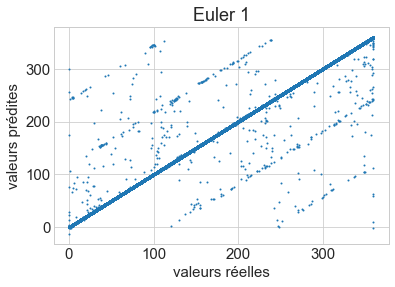

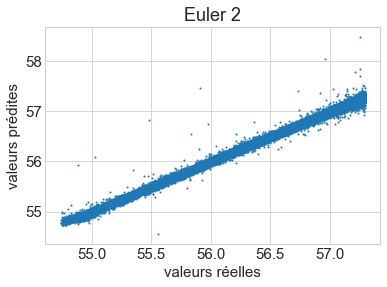

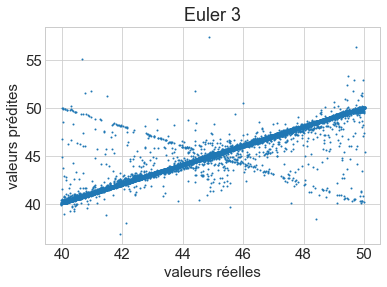

In [84]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_4[:, i], val_predictions4[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()
# plt.scatter(X_test, y_test, label="Données d'évaluation", color="b")

on affiche le nombre d'erreurs que fait notre modèle sur ces nouvelles données

In [85]:
predictions3 = model.predict(X_3)
message3, erreur_y3, erreur_x3, nb_error_3 = pourcentage_erreur(predictions3, y_3, X_3)
print(message3)
predictions4 = model.predict(X_4)
message4, erreur_y4, erreur_x4, nb_error_4 = pourcentage_erreur(predictions4, y_4, X_4)
print(message4)
predictions5 = model.predict(X_5)
message5, erreur_y5, erreur_x5, nb_error_5 = pourcentage_erreur(predictions5, y_5, X_5)
print(message5)

le pourcentage d'erreur est de 0.2728, 682 / 250000
le pourcentage d'erreur est de 0.29719999999999996, 743 / 250000
le pourcentage d'erreur est de 0.29, 725 / 250000


In [58]:
erreur_y2.shape

(288, 3)

In [59]:
erreur_x2.shape

(288, 22)

On récupère les valeurs d'entrée et de sortie X ey y des trois jeux de données pour lesquelles le modèle prédit mal dans trois matrices et on les mélanges à 50% d'autres valeurs aléatoires pour avoir trois jeux de données composés de 50% d'erreurs et 50% d'autres valeurs aléatoires.

In [86]:
matrix_y3 = np.ones((1, 3), dtype=float)
matrix_x3 = np.ones((1, 22), dtype=float)

for i in range(nb_error_3):
    nb = np.random.randint(0, X_3.shape[0] - 1)
    matrix_y3 = np.append(matrix_y3, [y_3[nb]], axis=0)
    matrix_x3 = np.append(matrix_x3, [X_3[nb]], axis=0)
    
matrix_y3 = np.delete(matrix_y3, 0, axis=0)
matrix_x3 = np.delete(matrix_x3, 0, axis=0)
# ==============================================
matrix_y4 = np.ones((1, 3), dtype=float)
matrix_x4 = np.ones((1, 22), dtype=float)

for i in range(nb_error_4):
    nb = np.random.randint(0, X_4.shape[0] - 1)
    matrix_y4 = np.append(matrix_y4, [y_4[nb]], axis=0)
    matrix_x4 = np.append(matrix_x4, [X_4[nb]], axis=0)
    
matrix_y4 = np.delete(matrix_y4, 0, axis=0)
matrix_x4 = np.delete(matrix_x4, 0, axis=0)
#=============================================
matrix_y5 = np.ones((1, 3), dtype=float)
matrix_x5 = np.ones((1, 22), dtype=float)

for i in range(nb_error_5):
    nb = np.random.randint(0, X_5.shape[0] - 1)
    matrix_y5 = np.append(matrix_y5, [y_5[nb]], axis=0)
    matrix_x5 = np.append(matrix_x5, [X_5[nb]], axis=0)
    
matrix_y5 = np.delete(matrix_y5, 0, axis=0)
matrix_x5 = np.delete(matrix_x5, 0, axis=0)

In [87]:
matrix_x3.shape

(682, 22)

In [88]:
matrix_y3.shape

(682, 3)

On regroupe les trois matrices précédentes dans une seule

In [89]:
new_X3 = np.concatenate((matrix_x3, erreur_x3), axis=0)
new_Y3 = np.concatenate((matrix_y3, erreur_y3), axis=0)

new_X4 = np.concatenate((matrix_x4, erreur_x4), axis=0)
new_Y4 = np.concatenate((matrix_y4, erreur_y4), axis=0)

new_X5 = np.concatenate((matrix_x5, erreur_x5), axis=0)
new_Y5 = np.concatenate((matrix_y5, erreur_y5), axis=0)

new_X_ = np.concatenate((new_X3, new_X4), axis=0)
new_Y_ = np.concatenate((new_Y3, new_Y4), axis=0)

new_X = np.concatenate((new_X_, new_X5), axis=0)
new_Y = np.concatenate((new_Y_, new_Y5), axis=0)

In [90]:
new_X.shape

(4300, 22)

In [91]:
new_Y.shape

(4300, 3)

on sépare nos nouvelles données composé de 50% d'erreurs et 50% aléatoire en 80 % de données d'entraîenement et 20 % données de test

In [92]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X, new_Y, test_size=0.2, random_state=1)

on crée un nouveau modèle avec le meme nombre de couches que le précédent

on donne au modèle nos nouvelles données composées de 50% d'erreurs et 50% d'aléatoires
on peut jouer avec le batch_size , le nombre d'epochs etc
augmenter le batch_size et réentrâiner plusieurs fois

In [93]:
model.compile(
    optimizer="adam", 
    loss="mae", # mse
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

history = model.fit(
    x=X_train2, 
    y=y_train2, 
    epochs=10000,
    batch_size=32,
    validation_data=(X_test2, y_test2)
)

Epoch 1/10000
108/108 [==============================] - 0s 2ms/step - loss: 12.3136 - mean_absolute_error: 12.3136 - val_loss: 11.4283 - val_mean_absolute_error: 11.4283
Epoch 2/10000
108/108 [==============================] - 0s 817us/step - loss: 11.6275 - mean_absolute_error: 11.6275 - val_loss: 12.0875 - val_mean_absolute_error: 12.0875
Epoch 3/10000
108/108 [==============================] - 0s 808us/step - loss: 10.6627 - mean_absolute_error: 10.6627 - val_loss: 10.9912 - val_mean_absolute_error: 10.9912
Epoch 4/10000
108/108 [==============================] - 0s 1ms/step - loss: 10.7308 - mean_absolute_error: 10.7308 - val_loss: 12.0131 - val_mean_absolute_error: 12.0131
Epoch 5/10000
108/108 [==============================] - 0s 1ms/step - loss: 11.1946 - mean_absolute_error: 11.1946 - val_loss: 12.6810 - val_mean_absolute_error: 12.6810
Epoch 6/10000
108/108 [==============================] - 0s 855us/step - loss: 11.1714 - mean_absolute_error: 11.1714 - val_loss: 12.8539 - v

KeyboardInterrupt: 

ou bien on utilise le modèle précédent ou un autres

on fait prédire à notre nouveau modèle toutes les données des trois fichiers (les modèles ne les ont jamais vu)

In [ ]:
pred3 = model.predict(X_3)
pred4 = model.predict(X_4)
pred5 = model.predict(X_5)

on fait aussi prédire nos données composés de 50% d'erreurs et 50% aléatoires

In [ ]:
pred = model.predict(new_X)

on affiche trois graphique pour visualiser la qulaité du modèle sur les données 50 50

NameError: name 'pred' is not defined

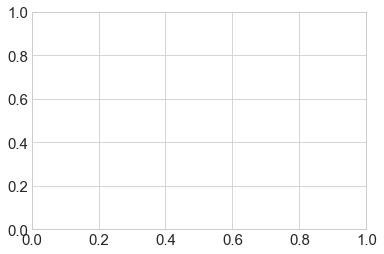

In [94]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(new_Y[:, i], pred[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()

on affiche aussi trois graphiques pour visulaiser les performances du modèles sur toutes les données d'un des fichiers importés

In [ ]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_4[:, i], pred4[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()

on calcule le nombre d'erreurs de 1 degré ou plus sur les données 50 50

In [ ]:
msg, erry, errx, err = pourcentage_erreur(pred, new_Y, new_X)
print(msg)

on calcule le nombre d'erreurs de 1 degré ou plus sur les trois fichiers de données

In [ ]:
message3, erreur_y3, erreur_x3, err3 = pourcentage_erreur(pred3, y_3, X_3)
print(message3)

message4, erreur_y4, erreur_x4, err4 = pourcentage_erreur(pred4, y_4, X_4)
print(message4)

message5, erreur_y5, erreur_x5, err5 = pourcentage_erreur(pred5, y_5, X_5)
print(message5)

On va réentraîner notre modèle_erreur avec les les données d'un des fichiers après qu'il s'est entraîner avec des données 50% erreur 50% aléaatoire et qu'il a a baissé à 10% d'erreurs sur les données 50 50

In [ ]:
model.compile(
    optimizer='adam',    # opti,
    loss="mae",    # "mae", # mse
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [ ]:
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size = 10000,
    epochs=2000,
    validation_data=(X_test, y_test)
)

On test mainetanant notre modèle sur les données des trois fichiers

In [77]:
predictions3 = model.predict(X_3)
message3, erreur_y3, erreur_x3, nb_error_3 = pourcentage_erreur(predictions3, y_3, X_3)
print(message3)
predictions4 = model.predict(X_4)
message4, erreur_y4, erreur_x4, nb_error_4 = pourcentage_erreur(predictions4, y_4, X_4)
print(message4)
predictions5 = model.predict(X_5)
message5, erreur_y5, erreur_x5, nb_error_5 = pourcentage_erreur(predictions5, y_5, X_5)
print(message5)

le pourcentage d'erreur est de 0.2728, 682 / 250000
le pourcentage d'erreur est de 0.29719999999999996, 743 / 250000
le pourcentage d'erreur est de 0.29, 725 / 250000
